# Поиск по изображениям

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.

Цель: разработка поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены, сервис выводит несколько фотографий с такой же или похожей сценой.

Для демонстрационной версии нужно выбрать лучшую модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.

Юридические ограничения: в некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

## Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению


В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
 
1. Имя файла изображения.
2. Идентификатор описания.
3., 4., 5. — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.
    
  В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>
   
  В папке test_images содержатся изображения для тестирования модели.

In [1]:
!pip install resnet-pytorch >> None

In [2]:
!pip install transformers >> None

In [3]:
# импортируем библиотеки и инструменты
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sys
import transformers
from transformers import BertTokenizer, BertModel
import os
from os.path import exists, isfile, join
from PIL import Image
from torchvision import transforms, models
from tqdm.notebook import tqdm, trange
import pickle
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from IPython.display import display
from sklearn.metrics import mean_squared_error
from ipywidgets import IntProgress
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from resnet_pytorch import ResNet
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import (decode_predictions, preprocess_input)
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для получения повторяемых результатов, зафиксируем состояния герераторов случайных чисел


In [5]:
np.random.seed(42)
tf.random.set_seed(42)

## Загрузка и исследовательский анализ данных

In [6]:
if exists("./data"):
  data_path = "./data"
else:
  data_path = "/content/drive/MyDrive/Colab Notebooks/datasets"

In [7]:
train_path = join(data_path, "train_images")
test_path = join(data_path, "test_images")

In [8]:
train_dataset = pd.read_csv(join(data_path, "/content/drive/MyDrive/Colab Notebooks/datasets/train_dataset.csv"))

In [9]:
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [10]:
train_dataset.describe()

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


На тренировочном множестве у нас 1000 уникальных изображений, имеющих 5822 связей с описаниями, 977 из которых уникальны.

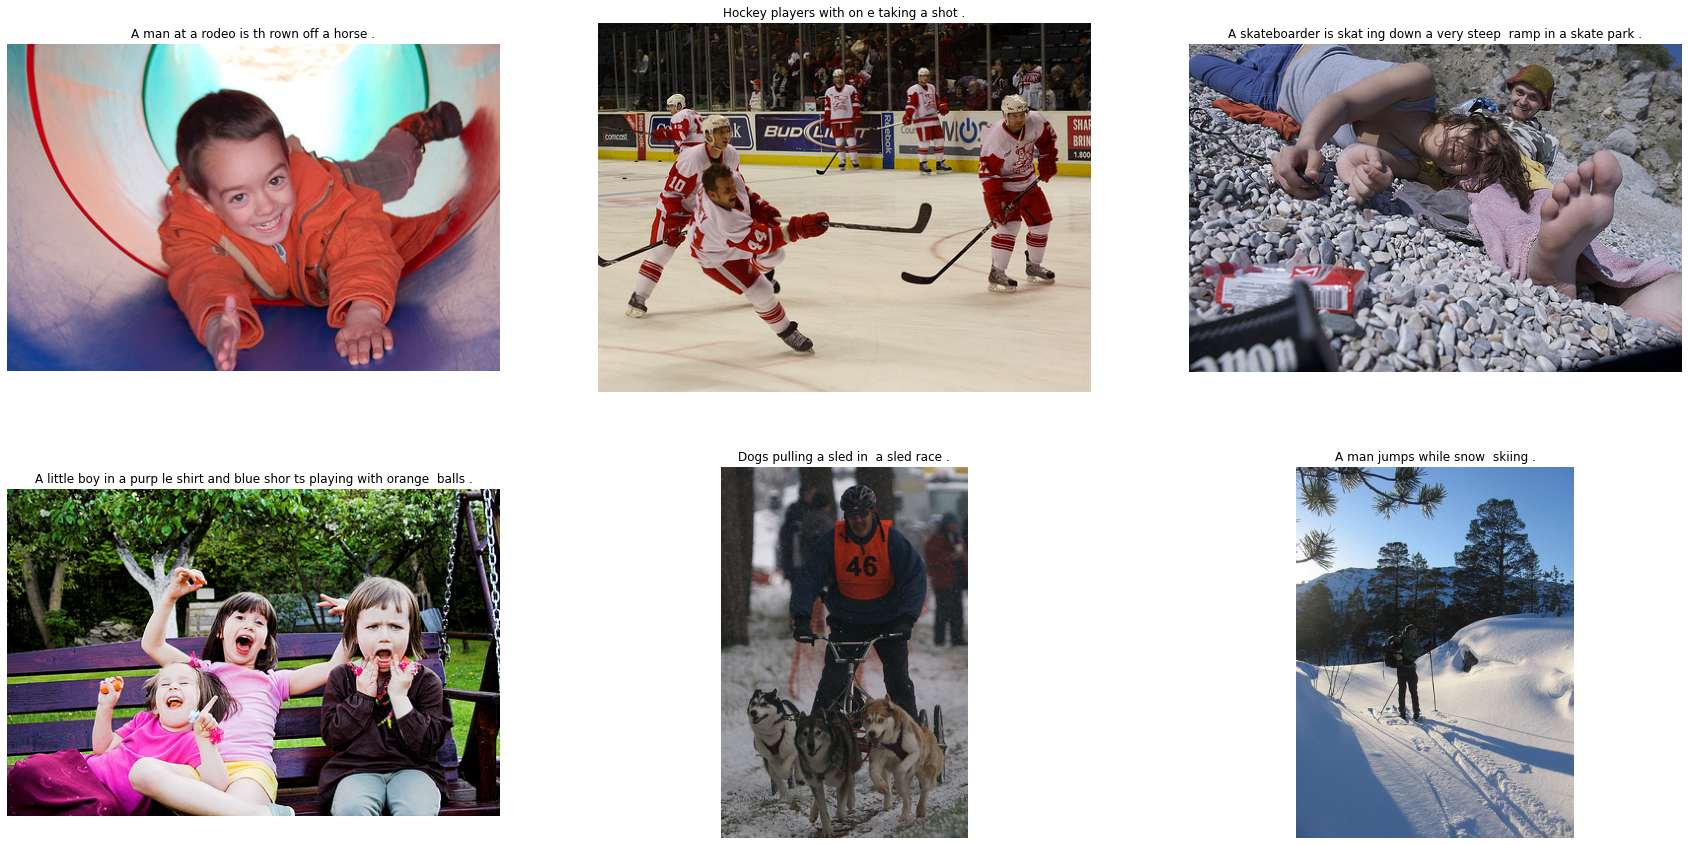

In [11]:
rows = 2
columns = 3
    
fig = plt.figure(figsize=(30, 15))
count = 1
for _, file, _, query_text in train_dataset.sample(rows * columns).itertuples():
  img = Image.open(join(train_path, file))
  fig.add_subplot(rows, columns, count)
  count += 1
  plt.imshow(np.array(img))
  plt.axis("off")
  title = query_text
  chunks, chunk_size = len(query_text), 22
  plt.title(" ".join([query_text[i : i + chunk_size] for i in range(0, chunks, chunk_size)]))

Для дальнейшей работы будет удобнее переименовать столбец query_id

In [12]:
 train_dataset = train_dataset.rename(columns={"query_id": "annotation_id"})

Читаем экспертные оценки точности анотирования фото

In [13]:
expert_annotations = pd.read_csv(join(data_path, "ExpertAnnotations.tsv"), sep="\t", header=0)
expert_annotations.head()

,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1.1,1.2
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1


In [14]:
expert_annotations.columns = ["image", "annotation_id", "score_1", "score_2", "score_3"]

In [15]:
expert_annotations.head()

,image,annotation_id,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1


In [16]:
expert_annotations.describe()

,score_1,score_2,score_3
count,5821.000000,5821.000000,5821.000000
mean,1.436695,1.624463,1.882151
std,0.787130,0.856256,0.904091
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Имеем 5821 эксперных оценок. Качество данных не высоко: медиана у двух экспертов из 3 равна 1, т.е. эксперты считают, что половина изображений и их описаний совершенно не соответствуют друг другу. И лишь один эксперт считает, что в половине случаев запрос содержит элементы описания изображения, но в целом фото тексту не соответствует.




Посмотрим на данные по соответствию изображения и описания, полученные с помощью краудсорсинга.

In [17]:
crowd_annotations = pd.read_csv(join(data_path, "CrowdAnnotations.tsv"), sep="\t", header=0)
crowd_annotations.head()

,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1,3,0
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.0,0,3


In [18]:
crowd_annotations.columns = ["image", "crowd_annotations_id", "score_1", "score_2", "score_3"]
crowd_annotations.describe()

,score_1,score_2,score_3
count,47829.000000,47829.000000,47829.000000
mean,0.068766,0.208430,2.820214
std,0.207490,0.628775,0.656556
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


Имеем 47 829 оценок. Более чем в 75% изображений, люди отметили не соответствие описания изображению.

Теперь читаем наборы тестовых данных

In [19]:
test_queries = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/test_queries.csv", sep="|", index_col=0)
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [20]:
test_queries.describe()

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


В тестовой выборке 100 уникальных фото, которым соответствует 500 уникальных описаний. 

In [21]:
test_images = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/test_images.csv")
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [22]:
test_images.describe()

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


## Подготовка данных

### Построение сводной экспертной оценки
   
Согласно заданию, после анализа экспертных и краудсорсинговых оценок можно выбрать одну атегорию оценок: экспертная или краудсорсинговая. Выбираем экспертную.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи эти оценки агрегируем, т.е. превращаем в одну. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст исключим из датасета. Посчитаем вес каждой оценки и выведем общую.

In [23]:
key_weights = {
    1: 0.0,
    2: (1 - (1 / 3 *2)) / 3,
    3: (1 - (1 / 3)) / 3,
    4: 1 / 3
}

In [24]:
 def voting(v1, v2, v3):
  ''' функция принимает тройку оценок и возвращает ту, что совпадает хотя бы у двоих, иначе возвращает None '''
  if v1 == v2 or v1 == v3:
    return round(key_weights[v1] + key_weights[2] + key_weights[3], 2)
  elif v2 == v3:
    return round(key_weights[v1] + key_weights[2] + key_weights[3], 2)
  else:
    return None

In [25]:
expert_annotations["experts"] = expert_annotations.apply(lambda x: voting(x["score_1"], x["score_2"], x["score_3"]), axis=1)

Удаляем несогласованные оценки

In [26]:
expert_annotations.dropna(subset=["experts"], inplace=True)

In [27]:
expert_annotations.shape

(5695, 6)

Наложим полученные экспертные оценки на тренировочный датасет.

In [28]:
train_dataset = (train_dataset.set_index(["image", "annotation_id"]).join(
    expert_annotations.set_index(["image", "annotation_id"])[["experts"]],
    how="inner").reset_index())

In [29]:
train_dataset.head()

,image,annotation_id,query_text,experts
0,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.33
1,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.33
2,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.67
3,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.33
4,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.44


Посмотрим интервал получившихся оценок

In [30]:
print('min', train_dataset['experts'].min())
print('max', train_dataset['experts'].max())

min 0.33
max 0.67


Проверим отражает ли наш подход действительность.

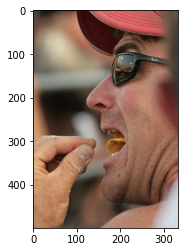

In [31]:
img = Image.open(join(train_path, "2621415349_ef1a7e73be.jpg"))
plt.imshow(np.array(img));

In [32]:
train_dataset.query('image == "2621415349_ef1a7e73be.jpg"')

,image,annotation_id,query_text,experts
3,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.33
2874,2621415349_ef1a7e73be.jpg,143688283_a96ded20f1.jpg#2,A man in a white shirt and helmet is using cli...,0.33
3385,2621415349_ef1a7e73be.jpg,491405109_798222cfd0.jpg#2,A small girl is doing a handstand while smiling,0.33
3619,2621415349_ef1a7e73be.jpg,3315616181_15dd137e27.jpg#2,A teenage boy climbs an indoor climbing wall .,0.33
4077,2621415349_ef1a7e73be.jpg,3503689049_63212220be.jpg#2,a young man wearing dark sunglasses smiling,0.56
4158,2621415349_ef1a7e73be.jpg,2966552760_e65b22cd26.jpg#2,A smiling child sits against a wall on a blank...,0.44
4640,2621415349_ef1a7e73be.jpg,2396691909_6b8c2f7c44.jpg#2,A young girl with makeup and jewelry smiles .,0.33
4955,2621415349_ef1a7e73be.jpg,2675685200_0913d84d9b.jpg#2,a young boy making a big mess on the floor and...,0.33
5096,2621415349_ef1a7e73be.jpg,3655074079_7df3812bc5.jpg#2,A naked woman wearing body paint riding a bicy...,0.33


Да, описание довольно неплохо отражает изображение. Оставляем эти значения для дальнейшего обучения.

### Лемматизация описаний
Для начала лемматизируем описания фотографий. Потом применим к леммам векторайзер.

In [33]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [35]:
lemmatizer = WordNetLemmatizer()

Для дальнейшей работы тексты нужно лемматизировать и токенизировать. В ряде случаев для правильной лемматизации лемматезатору требуется уточнение, какой частью речи является слова (POS). Эту информацию также можно получить средствами nltk.

In [36]:
def pos_tag(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
  return tag_dict.get(tag, wordnet.NOUN)

In [37]:
%%time
train_dataset["lemm_query"] = train_dataset["query_text"].apply(
    lambda x: " ".join(
        [lemmatizer.lemmatize(w, pos_tag(w)) for w in nltk.word_tokenize(x)]))

CPU times: user 9.46 s, sys: 568 ms, total: 10 s
Wall time: 10.6 s


In [38]:
train_dataset["lemm_query"] = train_dataset["lemm_query"].apply(
    lambda x: (" ".join(re.sub(r"[^a-zA-Z ]", " ", x).split()).lower()))

### Удаление проблемного контента

Составим список слов, используемых в английском языке для обозначения детей и подростков и напишем функцию, которая будет искать эти слова в лемматезированных текстах.
   

In [39]:
child_stop = [
    "boy", "boys",
    "girl", "girls",
    "child", "children",
    "baby", "babies",
    "kid", "kids",
    "babe",
    "infant",
    "teenager", "teenagers",
    "teeny", 
    "juvenile",
    "teener",
    "stripling",
    "toddler"
]

In [40]:
#Последовательно ищем слова из стоп-листа child_stop в заданном тексте text. Возвращаем True, если нашлось хотя бы одно слово

def child_in_text(str):
    for word in child_stop:
        if word.lower() in str.lower():
            return True
    return False

In [41]:
train_dataset["child"] = train_dataset.apply(
    lambda x: child_in_text(x["lemm_query"]), axis=1
) 

Удаляем найденные изображения с детьми. Для этого сначала составляем список изображений, где обнаружены дети, потом удаляем все записи, содержащие эти изображения.

In [42]:
train_dataset.shape

(5695, 6)

Оставляем в train_dataset_high_experts только те изображения, в которых степень соответствия описанию больше 0.5, для последующего удаления фото детей.

In [43]:
train_dataset_high_experts = train_dataset[train_dataset["experts"] >= 0.5]

In [44]:
child_images = set(train_dataset_high_experts[train_dataset["child"] == True]["image"])

In [45]:
train_dataset = train_dataset.drop(
    train_dataset[train_dataset["image"].isin(child_images)].index, axis=0)

In [46]:
train_dataset.shape

(5256, 6)



Осталось 5256 описаний. Удалены 439 строк содержащих в описании детей.

Удалим столбец "child", он больше не понадобится.


In [47]:
train_dataset = train_dataset.drop("child", axis=1)

### Векторизация описаний
    
  Используем для векторизации BERT. 

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [49]:
tokenized = train_dataset['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len: 
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [50]:
model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)  
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [52]:
attention_mask.shape

(5256, 36)

In [53]:
max_len

36

In [54]:
padded.shape

(5256, 36)

In [55]:
%%time

def get_vectors_bert(model, input_id, mask, batch_size): 
     
    embeddings = [] 
    for i in tqdm(range(input_id.shape[0] // batch_size)): 
        batch = torch.tensor(input_id[batch_size*i:batch_size*(i+1)], device=device)  
        attention_mask_batch = torch.tensor(mask[batch_size*i:batch_size*(i+1)], device=device) 
         
        with torch.no_grad(): 
            batch_embeddings = model(batch, attention_mask=attention_mask_batch) 
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy()) 
    return embeddings

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.82 µs


In [56]:
embeddings = get_vectors_bert(model, padded, attention_mask, batch_size=1)

  0%|          | 0/5256 [00:00<?, ?it/s]

In [57]:
train_embeddings = np.concatenate(embeddings) 
train_dataset = train_dataset[['image', 'experts']][:-1].reset_index(drop=True)

In [58]:
train_dataset =  pd.concat([train_dataset, pd.DataFrame(train_embeddings)], axis=1)

In [59]:
train_dataset.head()

,image,experts,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,1262583859_653f1469a9.jpg,0.33,-0.047877,0.051415,-0.272813,-0.072299,0.047598,-0.743571,0.045497,0.837147,-0.502959,-0.20005,-0.373808,-0.868144,-0.136541,0.841684,0.671735,0.005682,-0.62385,0.692181,0.32507,-0.036144,-0.007949,-0.279216,0.040704,-0.245721,0.239937,-0.172244,0.02911,0.317958,0.306031,0.148552,-0.29245,0.370667,-0.478776,-0.690627,0.527599,0.082748,0.046709,-0.105448,0.037976,0.252085,-0.412764,-0.163301,0.113242,-0.428196,0.079556,-1.093479,-2.245621,0.085894,-0.329142,0.063317,-0.287647,-0.125973,0.392573,0.191674,-0.279191,0.314803,-0.006494,0.271117,0.216569,-0.085387,0.727949,-0.068926,-0.276115,-0.568541,-0.590047,0.224242,-0.53596,0.071516,-0.146056,-0.393771,-0.569185,0.00032,-0.197966,-0.543011,-0.117973,0.100402,0.104818,0.257378,-0.677357,-0.590513,-0.052704,0.610248,0.89603,0.974591,0.250592,-0.282817,-0.643617,-0.151122,0.04284,0.216814,-0.46874,0.021244,-0.283381,1.11914,-0.206652,0.778578,0.077766,0.379181,0.48378,0.073997,0.614681,0.036923,0.985352,-0.435353,0.425245,0.0768

In [60]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5256 entries, 0 to 5255
Columns: 770 entries, image to 767
dtypes: float32(768), float64(1), object(1)
memory usage: 15.5+ MB


### Векторизация изображений

Задача векторизации изображений с помощью свёрточной нейросети. 
Используем ResNet18, обученную на ImageNet, так что нужно привести изображения к формату (224, 224, 3).

In [61]:
# готовим необходимые входные размеры для CNN
inputDim = (224,224)
inputDir = '/content/drive/MyDrive/Colab Notebooks/datasets/train_images'
inputDirCNN = '/content/drive/MyDrive/Colab Notebooks/datasets/train_images_CNN'

os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

for imageName in os.listdir(inputDir):
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)
    newI.save(os.path.join(inputDirCNN, imageName)) #, exif=exif)
    newI.close()
    I.close()

In [62]:
class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device(device)
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
      
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

# генерируем векторы для всех изображений
img2vec = Img2VecResnet18() 

allVectors = {}
print("Преобразование изображений в векторные объекты:")
for image in tqdm(os.listdir("/content/drive/MyDrive/Colab Notebooks/datasets/train_images_CNN")):
    I = Image.open(os.path.join("/content/drive/MyDrive/Colab Notebooks/datasets/train_images_CNN", image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close() 

Преобразование изображений в векторные объекты:


  0%|          | 0/1000 [00:00<?, ?it/s]

Сводим векторные принаки в датафрейм

In [63]:
image_df = pd.DataFrame(allVectors)
image_df = image_df.T.reset_index()
image_df = image_df.rename(columns={"index": "image"})

In [64]:
image_df.head()

,image,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,2966552760_e65b22cd26.jpg,0.075382,0.415348,0.317930,0.223243,0.650326,1.516366,0.290243,0.349993,1.609858,2.298426,0.964854,0.604956,1.873362,0.671316,1.261359,2.254909,0.519623,0.073612,0.568023,1.086942,1.123179,1.046359,1.412630,1.094217,0.307994,0.996701,1.079081,3.436525,0.902861,1.001596,0.682442,1.627080,1.780578,0.154971,0.912498,2.306210,1.870476,0.876909,0.322121,2.394325,1.858905,1.332708,1.964354,2.729177,0.844080,0.358659,0.292897,4.356458,0.791334,0.435994,1.217594,2.145576,1.114244,1.250068,0.137997,0.602630,0.267692,1.558245,2.015649,0.144488,0.218330,0.897124,0.833815,1.603181,1.755368,1.943622,0.869166,1.616588,0.533534,0.990528,0.907113,1.493769,0.089872,0.559157,0.833063,1.085776,0.350455,1.142046,0.100907,1.281474,1.623541,2.450078,0.694381,4.275151,0.350720,1.267185,0.109514,1.323977,2.382939,2.939099,0.219039,0.200086,0.062977,0.810067,2.423965,2.764006,0.853954,2.552347,1.459467,0.858174,0.972546,1.661525,0.435242,0.092211,1.150283,0.290287,1.791825,0.910612,0.420743,0.705419,6.296460,1.806708,0.155761,1.697730,1.954757,0.144349,1.744451,0.702425,4.602015,1.228310,0.580529,1.876747,2.358341,1.154079,0.494491,0.537211,0.546503,0.795312,1.501628,0.336957,0.488063,1.354408,0.964372,1.201844,0.541052,0.296632,1.124416,0.253046,2.118295,1.953179,0.078221,0.975612,1.182423,0.968193,0.788389,0.250629,0.966433,3.090573,1.482798,0.552193,1.660351,1.885407,3.264825,1.632748,0.661121,0.274252,0.564977,0.118289,0.643669,1.105529,1.021825,0.020178,0.396673,3.512394,0.245023,0.267609,0.390614,0.359899,0.247617,0.191564,0.435651,1.640463,0.910961,0.968709,0.275548,3.972673,0.284327,1.682594,0.028657,1.115252,1.154143,0.617058,0.046371,0.205222,0.189088,0.401917,0.303123,0.394977,0.228551,1.914241,1.205295,0.300609,1.076149,0.752198,0.501584,0.255386,0.781275,0.961573,1.239955,0.247145,1.263863,1.640384,1.017382,0.021620,0.162962,0.581486,0.308804,0.675597,0.378751,0.038638,0.729195,0.100027,1.330661,1.677056,0.009632,0.027663,1.294760,1.303526,2.642084,3.622300,2.840228,0.102999,0.347027,1.958913,3.593449,1.

Объединим веторные принаки описания и изображений в один датафрейм

In [65]:
train_dataset = train_dataset.merge(image_df, on = 'image', how = 'inner')

In [66]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5255 entries, 0 to 5254
Columns: 1282 entries, image to 511_y
dtypes: float32(1280), float64(1), object(1)
memory usage: 25.8+ MB


Теперь можно строить модель для сопоставления векторов между собой.

### Вывод

1. Была построена единая экспертная оценка.
2. Удалены 439 изображений, в описаниях которых упоминались дети и подростки, при этом общая оценка меры соответствия >= 0.5.
3. С BERT векторизованы описания изображений в тренировочном датасете. 
4. С помощью свёрточной нейросети ResNet18 векторизованы изображения. 

## Обучение моделей
 
Обучим модели: линейную регрессию и нейросеть.


Разделим датасет на тренировочную и валидационную части, так чтобы изображения в тренировочной выборке не повторялись в валидационной.

In [67]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
train_indices, val_indices = next(
    gss.split(
        X=train_dataset.drop(columns=["experts"]),
        y=train_dataset["experts"],
        groups=train_dataset["image"],
    )
)
train__df, val__df = train_dataset.iloc[train_indices], train_dataset.iloc[val_indices]


In [68]:
X_train = train__df.drop(columns=['experts', 'image'], axis=1)
y_train = train__df['experts']

In [69]:
X_val = val__df.drop(columns=['experts', 'image'], axis=1)
y_val = val__df['experts']

### Линейная регрессия
    

In [70]:
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
pred_LR = model_LR.predict(X_val)
score_LR = mean_squared_error(y_val, pred_LR)
print(score_LR**0.5)

0.10737998809083493


Линейная регрессия показала RMSE 0.1. Это не плохой результат.



### Нейронная сеть

In [71]:
X_train = torch.FloatTensor(X_train.values)
X_val = torch.FloatTensor(X_val.values)
y_train = torch.FloatTensor(y_train.values)
y_val = torch.FloatTensor(y_val.values)

In [72]:
n_in_neurons, n_out_neurons = X_train.shape[1], 1
n_hidden_neurons_1 = 14
n_hidden_neurons_2 = 35
n_out_neurons = 1
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
       
        x = self.fc2(x)
        x = self.act2(x)
       
        x = self.fc3(x)
        return x

In [73]:
def train(net, x_train, y_train, x_test, y_test, epoches, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    epoches = epoches
    train_losses = []
    test_losses = []
    test_preds = []
    for i in range(epoches):
        optimizer.zero_grad()
        preds = net(x_train).flatten()
        loss_train = torch.sqrt(criterion(preds, y_train))
        loss_train.backward()
        optimizer.step()
        with torch.no_grad():
            preds_test = net(x_test).flatten()
            loss_test = torch.sqrt(criterion(preds_test, y_test))
            sys.stdout.write('\r Epoch: %d, loss_train: %.5f, loss_test: %.5f'
                                %(i, loss_train.item(), loss_test.item()))
            sys.stdout.flush()
            train_losses.append(loss_train.item())
            test_losses.append(loss_test.item())
            if i == epoches - 1:
                preds_t = net(x_test).flatten().detach().numpy()
                test_preds.append(preds_t)
    return train_losses, test_losses, test_preds

In [74]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses_final, test_losses_final, test_preds = train(net, X_train, y_train, 
                                                          X_val, y_val, 500, 0.001)

Net(
  (fc1): Linear(in_features=1280, out_features=14, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=14, out_features=35, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=35, out_features=1, bias=True)
)
 Epoch: 499, loss_train: 0.05207, loss_test: 0.08571

In [75]:
rmse_nn = min(test_losses_final)

In [76]:
print (f'Значение RMSE: {rmse_nn}')

Значение RMSE: 0.08022032678127289


На валидаионной выборке лучшее значение RMSE составило 0.078.

In [77]:
'''функция испольования нейросети для предсказания целевой переменной'''
def test(net, x_test, epoches, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    epoches = epoches
    test_preds = []
    for i in range(epoches):
        optimizer.zero_grad()
        optimizer.step()
        with torch.no_grad():
            preds_test = net(x_test).flatten()
            if i == epoches - 1:
                preds_t = net(x_test).flatten().detach().numpy()
                test_preds.append(preds_t)
    return test_preds

## Тестирование модели и финальная функция 

In [78]:
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [79]:
test_images.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [80]:
# готовим необходимые входные размеры для CNN тестовых изображений 
inputDim = (224,224)
inputDir_test = '/content/drive/MyDrive/Colab Notebooks/datasets/test_images'
inputDirCNN_test = '/content/drive/MyDrive/Colab Notebooks/datasets/test_images_CNN'

os.makedirs(inputDirCNN_test, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

for imageName in os.listdir(inputDir_test):
    I_test = Image.open(os.path.join(inputDir_test, imageName))
    newI_test = transformationForCNNInput(I_test)
    newI_test.save(os.path.join(inputDirCNN_test, imageName)) #, exif=exif)  
    newI_test.close()
    I_test.close()

In [81]:
# генерируем векторы для всех изображений

allVectors_test = {}
print("Преобразование изображений в векторные объекты:")
for image in tqdm(os.listdir("/content/drive/MyDrive/Colab Notebooks/datasets/test_images_CNN")):
    I_test = Image.open(os.path.join("/content/drive/MyDrive/Colab Notebooks/datasets/test_images_CNN", image))
    vec = img2vec.getVec(I_test)
    allVectors_test[image] = vec
    I_test.close() 

Преобразование изображений в векторные объекты:


  0%|          | 0/100 [00:00<?, ?it/s]

In [82]:
image_df_test = pd.DataFrame(allVectors_test)
image_df_test = image_df_test.T.reset_index()
image_df_test = image_df_test.rename(columns={"index": "image"})

In [83]:
image_df_test.head()

,image,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,269650644_059a84ece5.jpg,1.422799,1.274020,1.548098,0.789031,0.000000,1.085951,1.227722,1.477341,0.413673,2.085111,0.312475,0.483701,0.259506,0.789059,0.640425,1.616920,0.499840,0.593216,0.411116,1.479670,0.306179,2.431555,0.190326,1.191788,0.855592,0.801262,0.447978,3.001767,0.138540,0.299787,0.315644,0.406311,0.057650,0.526073,0.024360,0.787945,0.158408,0.429622,0.787073,3.129101,0.375177,0.431706,0.697780,0.497926,0.916695,1.596320,1.090483,0.403210,0.880858,0.172666,0.216987,0.385244,0.743396,1.421628,0.727196,0.533246,3.219239,0.897336,1.401808,1.473591,0.361519,0.828025,1.312436,1.220034,0.395511,3.499674,0.723596,0.437821,0.254096,1.225317,0.597358,0.700345,0.716009,0.458412,0.321506,1.897168,1.782849,0.145492,0.154560,1.511289,0.455407,0.516586,0.383489,1.702558,0.628977,0.193601,0.455580,0.036995,2.233222,1.937876,0.482314,0.250027,0.476429,0.127813,0.974275,0.422719,0.645802,2.323592,2.424828,0.509895,0.128933,0.970901,0.422043,0.923082,1.367029,0.538602,0.285824,0.199585,1.649001,1.169627,1.220683,1.869761,0.481436,0.359074,0.360634,0.598181,1.056597,0.687118,0.669153,0.458694,0.774151,2.163191,0.083711,1.673692,0.616845,0.669116,0.536169,0.404337,1.243235,0.238151,0.927616,0.629234,0.803061,0.311690,0.597085,1.623077,0.294391,1.751287,0.800216,0.454538,0.033494,1.036951,1.296005,1.073546,0.247629,0.654453,0.922647,0.223200,0.181441,2.536556,0.763081,0.045644,0.655323,0.070442,1.976324,0.182454,0.194359,1.174223,0.246207,1.953295,0.827529,0.349694,0.083268,3.310247,1.174432,0.688156,2.954084,1.433351,0.699240,0.352855,0.942926,0.014960,0.241529,0.876306,2.006714,0.682928,0.187520,0.392186,2.137568,0.240201,0.640963,1.154177,3.891665,1.554421,1.088704,0.372524,0.414691,1.057596,0.322007,2.000746,0.514393,0.602744,0.174076,2.780530,2.665280,0.805654,0.024956,2.121768,0.112794,3.715744,0.286778,2.087926,0.533636,0.314023,1.462059,2.770409,1.019700,1.087963,0.769860,0.469680,0.012883,0.176479,1.166389,1.324654,0.224971,0.354274,2.108305,0.701730,1.498982,0.196568,0.659158,0.022757,0.601975,1.141806,0.597143,1.1

Подотовим функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.

In [84]:
def test_token(text):
  ''' создаем вектор из входного текста '''
  tokenized_test = tokenizer.encode(text, add_special_tokens=True, truncation=True)
  padded_test = np.array([tokenized_test + [0]*(max_len - len(tokenized_test))])
  #padded_test = np.array([tokenized_test])
  attention_mask_test = np.where(padded_test != 0, 1, 0)                                 
  padded_test = torch.tensor(padded_test, device=device) 
  attention_mask_test = torch.tensor(attention_mask_test, device=device)
  embeddings_test = model(padded_test, attention_mask=attention_mask_test)
  embeddings_test = embeddings_test[0][:,0,:].detach().cpu().numpy()
  '''объединяем вектор входного текста с kаждым вектором изображения'''
  df_test = pd.concat([image_df_test, pd.DataFrame(embeddings_test)], axis = 1) 
  df_test = df_test.fillna(method = 'ffill', axis = 0)
  ''' удаляем столбец 'image' и переводим в тензор для нейронной сети '''
  df_test = df_test.drop('image', axis=1)
  df_test = torch.FloatTensor(df_test.values)
  ''' запускаем нейросеть и предсказываем меру соответствия входного текста и изображения'''
  test_preds = test(net, df_test, 500, 0.001)
  ''' объединяем полученные меры соответствия и наименования изображений '''
  df_preds = pd.concat([image_df_test['image'], pd.DataFrame(test_preds).T], axis = 1) 
  ''' переименовываем столбец меры соответствия'''
  df_preds = df_preds.rename(columns={0 : 'accordance'})
  ''' выбираем изображением с наибольшей мерой и выводим изображение '''
  test_string = df_preds.loc[df_preds['accordance'] == df_preds['accordance'].max()]
  image_name = test_string.iloc[0]['image']
  img = Image.open(join(test_path, image_name))
  return text, plt.imshow(np.array(img));

Подотовим функцию, которая принимает на вход текстовое описание и если запрос ведёт на юридически вредный контент, выводит дисклеймер.

In [85]:
def final(text):
  count = 0
  for word in text.split(): 
    if word in child_stop:
      count +=1   
  if count != 0:
    print('This image is unavailable in your country in compliance with local laws.')
  else:
    test_text, test_image = test_token(text)
    print(test_text)

Проверяем нашу работу.

In [86]:
test_queries.shape

(500, 3)

In [103]:
test_queries.sample(5)

,query_id,query_text,image
351,3459871361_92d1ecda36.jpg#1,A man is jumping his bicycle off of a ramp .,3459871361_92d1ecda36.jpg
480,957682378_46c3b07bcd.jpg#0,A brown dog and a black dog run into each othe...,957682378_46c3b07bcd.jpg
172,2737233999_34d60dc5c3.jpg#2,Four people playing basketball on wooden area ...,2737233999_34d60dc5c3.jpg
35,1745110280_0cbff5e273.jpg#0,A brown dog with a black collar stands next to...,1745110280_0cbff5e273.jpg
238,3122579598_14841c038a.jpg#3,Two children stand in the grass while a white ...,3122579598_14841c038a.jpg


A brown dog with a black collar stands next to a bush .


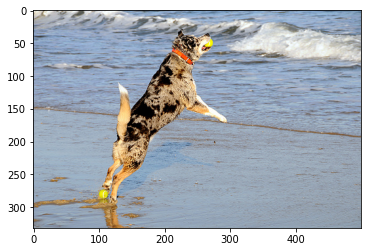

In [106]:
final(test_queries['query_text'][35])

# Вывод:
1. Обе модели показали почти одинаковое значение метрики RMSE. Но все-таки нейронная сеть показала себя немного лучше.
2. В целом модель показала свою жизнеспособность, но на итоговом тестировании наблюдаются значительные несоответствия описания и изображения. 

Возможные улучшения: использование более качественно размеченных данных, увеличение датасета.